## Explore how a vegetation index is calculated: effect of thresholding

In this illustration, we take as example one RGB image of a single plot (`.png` thumbnail from `drone2report`), and one vegetation index, **GLI** (Green Leaf Index (more [here](https://www.indexdatabase.de/db/i-single.php?id=375)).

We start by import libraries: we are using the `imageio` *Python* library for input/output of image data (png/tiff raster images in this illustration):

In [2]:
import numpy as np
import numpy.ma as ma
import imageio.v2 as imageio
import matplotlib.pyplot as plt

In [3]:
fname = '../../paper-drone2report/data/single_rgb_plot/single_rgb_plot.tif'
pic = imageio.imread(fname)

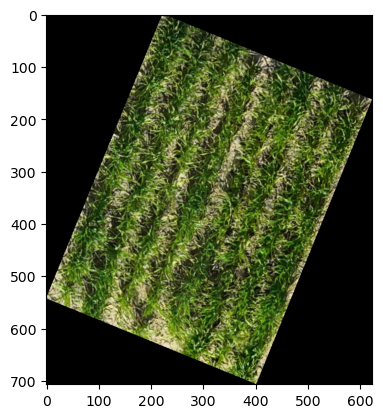

In [4]:
plt.figure()
plt.imshow(pic)

In [4]:
print('Shape of the image : {}'.format(pic.shape))

print('Total n. of pixels:', pic.shape[0]*pic.shape[1])

Shape of the image : (707, 623, 3)
Total n. of pixels: 440461


The input image has the characteristics detailed above, e.g. 3 channels and size 707 x 612 (height, width): **total number of input pixels is 432,684**.

## Calculating the GLI index

### Using drone2report

The GLI (Green Leaf Index) was calculated with the `drone2report` software, using [this configuration file: RGB_GLI.ini](https://github.com/ne1s0n/paper-drone2report/blob/main/support_material/RGB_GLI.ini).
The calculations were based on $254\,493$ pixels: 

- average GLI = 0.26837
- median GLI = 0.25397
- std dev GLI = 0.147
- min, max GLU = $[-0.3684, 0.98ì775]$

**<div style="color:red">Question: can GLI be negative?</div>**

### Step-by-step calculations

We need to change the Python environemnt settings so to ignore warnings that are raised when division by zero is encountered: this is something that can easily happen when you work with high dimensional arrays (there may be a zero somewhere):

In [35]:
## this is a setting to ignore warnings when attempting to divide by 0
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

Now, we calculate the GLI index manually:

1. we first define the three channels
2. we then separate the three channels from the `numpy` array:

In [38]:
channels = ['red','green','blue']
channels.index('red') ## index of the red channel

0

In [40]:
red   = pic[:,:,channels.index('red')]
green = pic[:,:,channels.index('green')]
blue  = pic[:,:,channels.index('blue')]

These are three 2D arrays of numbers (pixel intensities), corresponding to the three color channels: we see the zeros that correspond to the black pixels in the four corners around the crop plot (and this shows that we are bound to have divisions by zero):

In [41]:
red

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

We then take the equation to calculate the [GLI index](https://www.indexdatabase.de/db/i-single.php?id=375) and implement it using our arrays:

In [49]:
gli = (2.0*green - red - blue) / (2.0*green + red + blue)
gli[100:120, 220:280]

array([[0.33333333, 0.16738197, 0.14285714, ..., 0.43459916, 0.29449838,
        0.22921914],
       [0.28767123, 0.15736041, 0.15283843, ..., 0.30744337, 0.33333333,
        0.32867133],
       [0.5862069 , 0.38461538, 0.31764706, ..., 0.26011561, 0.35849057,
        0.42      ],
       ...,
       [0.66336634, 0.64516129, 0.49707602, ..., 0.07614213, 0.10854503,
        0.27179487],
       [0.55371901, 0.55555556, 0.61904762, ..., 0.078203  , 0.11020408,
        0.18461538],
       [0.47368421, 0.57480315, 0.64705882, ..., 0.15226337, 0.14285714,
        0.2125    ]])

We see that, due to the presence of manay divisions by zero, `nan` are introduced in the numpy array (missing or undetermined data points): 

In [50]:
gli

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Below, the **heatmap of the GLI values 2D array**: nan are displayed as white (missing values)

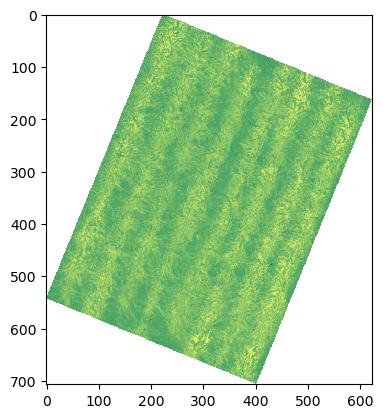

In [57]:
plt.imshow(gli, cmap='summer', interpolation='nearest')
plt.show()

To get the average value of the GLI index for the whole plot (as is done by `drone2report`), we can take the average: the standard `np.mean()` wouldn't work, as there ara `nan`'s in the data; therefore we use a modified version of the function that removes `nan`'s before calculating the average:

In [69]:
avg = np.nanmean(gli_values)
print("Average GLI value calculated manually, where divisions by zero returned NaN's:", round(avg,5))

Average GLI value calculated manually, where divisions by zero returned NaN's: 0.26808


We can force division to zero to return zero instead of `nan`:

In [58]:
x = (2.0*green - red - blue)
y = (2.0*green + red + blue)

gli = np.divide(x, y, out=np.zeros_like(x), where=y!=0)
gli[100:120, 220:280]

array([[0.33333333, 0.16738197, 0.14285714, ..., 0.43459916, 0.29449838,
        0.22921914],
       [0.28767123, 0.15736041, 0.15283843, ..., 0.30744337, 0.33333333,
        0.32867133],
       [0.5862069 , 0.38461538, 0.31764706, ..., 0.26011561, 0.35849057,
        0.42      ],
       ...,
       [0.66336634, 0.64516129, 0.49707602, ..., 0.07614213, 0.10854503,
        0.27179487],
       [0.55371901, 0.55555556, 0.61904762, ..., 0.078203  , 0.11020408,
        0.18461538],
       [0.47368421, 0.57480315, 0.64705882, ..., 0.15226337, 0.14285714,
        0.2125    ]])

In [59]:
gli

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In the **heatmap of the GLI values 2D array**, now the `nan` are replaced by 0's, i.e. max saturation of those pixels (depending on the chosen color map this will be displayed as the darkest possible color in that channel)

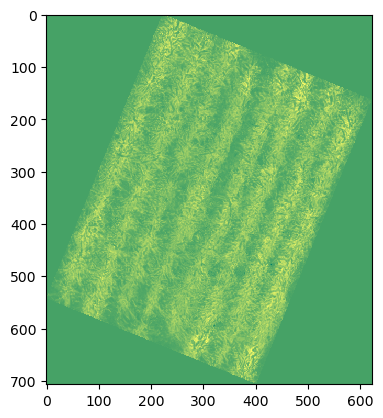

In [63]:
plt.imshow(gli, cmap='summer', interpolation='nearest')
plt.show()

Then we use a function to streamline and automate the different operations involved in the calculation of the GLI index:

In [10]:
def GLI(img, channels):
	"""Green leaf index, uses red, green, blue"""
	try:
		red   = img[:,:,channels.index('red')]
		green = img[:,:,channels.index('green')]
		blue  = img[:,:,channels.index('blue')]
	except ValueError:
		#if this clause is activated it means that the requested channel(s) are not available
		return np.nan
	#if we get here the index can be applied to the current image
	return(
		(2.0*green - red - blue) / 
		(2.0*green + red + blue)
	) 

In [11]:
gli_values = GLI(pic, channels)

array([[0.33333333, 0.16738197, 0.14285714, ..., 0.43459916, 0.29449838,
        0.22921914],
       [0.28767123, 0.15736041, 0.15283843, ..., 0.30744337, 0.33333333,
        0.32867133],
       [0.5862069 , 0.38461538, 0.31764706, ..., 0.26011561, 0.35849057,
        0.42      ],
       ...,
       [0.66336634, 0.64516129, 0.49707602, ..., 0.07614213, 0.10854503,
        0.27179487],
       [0.55371901, 0.55555556, 0.61904762, ..., 0.078203  , 0.11020408,
        0.18461538],
       [0.47368421, 0.57480315, 0.64705882, ..., 0.15226337, 0.14285714,
        0.2125    ]])

In [13]:
gli_values[100:120, 220:280]

array([[0.33333333, 0.16738197, 0.14285714, ..., 0.43459916, 0.29449838,
        0.22921914],
       [0.28767123, 0.15736041, 0.15283843, ..., 0.30744337, 0.33333333,
        0.32867133],
       [0.5862069 , 0.38461538, 0.31764706, ..., 0.26011561, 0.35849057,
        0.42      ],
       ...,
       [0.66336634, 0.64516129, 0.49707602, ..., 0.07614213, 0.10854503,
        0.27179487],
       [0.55371901, 0.55555556, 0.61904762, ..., 0.078203  , 0.11020408,
        0.18461538],
       [0.47368421, 0.57480315, 0.64705882, ..., 0.15226337, 0.14285714,
        0.2125    ]])

In [14]:
np.nanmean(gli_values)

0.2680817643550665

## Masked arrays

We first try masking unnecessary values of the index (the triangular margins outside of the ROI).
We do this by **masking index values calculated on out-of-shape pixels**.

This is a quick-n-dirty initial attempt.
A better way would be to mask directly the grey pixels in the input RGB image data (TODO)

In [ ]:
mask_0 = gli_values == 0

In [ ]:
masked_gli = ma.masked_array(gli_values, mask_0)

In [ ]:
masked_gli

#### N. of masked pixels

In [ ]:
np.ma.sum(mask_0)

#### N. of total pixels in the index matrix

Why fewer than the n. of pixels in the original image? $\rightarrow$ This is a png/jpeg thumbnail, not the original tiff file!! (lower resolution $\rightarrow$ fewer pixels)

In [ ]:
mask_0.shape[0] * mask_0.shape[1]

#### Average GLI value on single plot calculated after masking

Masking was based on GLI values (0s were masked):

In [ ]:
np.ma.mean(masked_gli)

### Masking directly the input data


In [ ]:
pic = imageio.imread(fname)

Sanity check: let's view the current image

In [ ]:
plt.figure()
plt.imshow(pic)

In [ ]:
pic[:,:,0]

In [ ]:
mask_0 = (pic[:,:,0] & pic[:,:,1] & pic[:,:,2] == 63)

In [ ]:
mask_0[100:160,160:220]

The n. of masked pixels is slightly different compared to the masking of the GLI index values:

In [ ]:
np.ma.sum(mask_0)

In [ ]:
mask_0.shape

In [ ]:
mask_tot = np.dstack((mask_0,mask_0,mask_0))
mask_tot.shape

In [ ]:
mask_tot[100:160,160:220,0]

In [ ]:
pic[120:160, 160:220, 2]

In [ ]:
masked_pic = ma.masked_array(pic, mask_tot)

In [ ]:
masked_pic[120:160, 180:220, 0]

In [ ]:
red   = masked_pic[:,:,channels.index('red')]
green = masked_pic[:,:,channels.index('green')]
blue  = masked_pic[:,:,channels.index('blue')]

In [ ]:
red[120:160, 180:220]

In [ ]:
temp = (2.0*green- red- blue) / (2.0*green + red + blue)
temp[120:160, 180:220]

In [ ]:
np.ma.mean(temp)

## Tiff image files

In [ ]:
fname = '../../paper-drone2report/data/example_RGB/single_RGB_plot.tiff'
pic = imageio.imread(fname)

In [ ]:
plt.figure()
plt.imshow(pic)

In [ ]:
print('Type of the image : ' , type(pic))
print()
print('Shape of the image : {}'.format(pic.shape))
print('Image Hight {}'.format(pic.shape[0]))
print('Image Width {}'.format(pic.shape[1]))
print('Dimension of Image {}'.format(pic.ndim))

In [ ]:
706*611

In [ ]:
from PIL import Image
im = Image.open(fname)
im.show()

In [ ]:
pic.shape

In [ ]:
imarray = np.array(im)
imarray